In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python numpy kagglehub

In [ ]:
!pip install tensorflow

In [ ]:
import cv2
import numpy as np
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.layers import Lambda, Flatten, Dense


In [ ]:
path = kagglehub.dataset_download("ruizgara/socofing", force_download=True)
print("Dataset path:", path)
print("Root contents:", os.listdir(path))

Dataset path: /kaggle/input/socofing
Root contents: ['SOCOFing', 'socofing']


In [ ]:
def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_last', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_last')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_last', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def inception_block_1a(X):
    """
    Implementation of an inception block
    """

    X_3x3 = Conv2D(96, (1, 1), data_format='channels_last', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_last', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    print(X_3x3.shape)

    X_5x5 = Conv2D(16, (1, 1), data_format='channels_last', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_last', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    print(X_5x5.shape)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_last')(X_pool)
    print(X_pool.shape)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
    print(X_1x1.shape)

    # CONCAT
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception


def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_last', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_last', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_last', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_last')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_last', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_last')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=-1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_last')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=-1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=-1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=-1)

    return inception

def imgRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet

    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)

    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = -1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Third Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = -1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)

    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)

    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)

    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)

    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)

    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_last')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)

    # L2 normalization
    X = Lambda(lambda  x: tf.math.l2_normalize(x,axis=1), output_shape=(128,))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='ImgRecoModel')

    return model

In [ ]:
from collections import defaultdict

from keras.layers import Input
from keras.models import Model
from keras import backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [ ]:
altered_path = os.path.join(path, "SOCOFing", "Altered")
real_path = os.path.join(path, "SOCOFing", "Real")

dic_alt_easy = get_data_dic(os.path.join(altered_path, "Altered-Easy"))
dic_alt_hard = get_data_dic(os.path.join(altered_path, "Altered-Hard"))
dic_alt_med = get_data_dic(os.path.join(altered_path, "Altered-Medium"))
dic_real = get_data_dic(real_path, train=False)

In [ ]:
def merge_data(dic1, dic2, dic3):

    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2

    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3

    return dic1

In [ ]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [ ]:
ids = list(dic_data.keys())
len(ids)

6000

In [ ]:
def get_batch_data(batch_size, ids, dic_data, dic_real):
    gen = get_train_data(ids, dic_data, dic_real)

    x1 = np.zeros((batch_size, 96, 96, 1), dtype='float32')
    x2 = np.zeros((batch_size, 96, 96, 1), dtype='float32')
    y = np.zeros((batch_size, 1), dtype='float32')

    while True:
        for i in range(0, batch_size, 2):
            anc_img, pos_img, neg_img = next(gen)

            x1[i] = anc_img
            x2[i] = pos_img
            y[i] = 1.0  # positive pair

            if i+1 < batch_size:
                x1[i+1] = anc_img
                x2[i+1] = neg_img
                y[i+1] = 0.0  # negative pair

        yield {'first_input': x1, 'second_input': x2}, y


In [ ]:
def get_train_data(ids, dic_data, dic_real):
    """
    Generates anchor, positive, and negative images in NHWC format.
    """
    while True:
        anc_id = np.random.choice(ids)
        pos_img_path = np.random.choice(dic_data[anc_id])

        neg_id = np.random.choice(ids)
        while neg_id == anc_id:
            neg_id = np.random.choice(ids)
        neg_img_path = np.random.choice(dic_data[neg_id])

        anc_img = cv2.imread(dic_real[anc_id][0], cv2.IMREAD_GRAYSCALE)
        pos_img = cv2.imread(pos_img_path, cv2.IMREAD_GRAYSCALE)
        neg_img = cv2.imread(neg_img_path, cv2.IMREAD_GRAYSCALE)

        # Resize, normalize, and convert to NHWC
        anc_img = np.expand_dims(cv2.resize(anc_img, (96, 96)).astype("float32") / 255.0, axis=-1)
        pos_img = np.expand_dims(cv2.resize(pos_img, (96, 96)).astype("float32") / 255.0, axis=-1)
        neg_img = np.expand_dims(cv2.resize(neg_img, (96, 96)).astype("float32") / 255.0, axis=-1)

        yield anc_img, pos_img, neg_img


In [ ]:
def draw_data(num):
    gen = get_batch_data(num, ids, dic_data, dic_real)
    x, y = next(gen)
    x1 = x['first_input']
    x2 = x['second_input']

    fig, ax = plt.subplots(num, 2, figsize=(10, num * 2))
    for i in range(num):
        ax[i][0].imshow(x1[i].squeeze(), cmap='gray')
        ax[i][1].imshow(x2[i].squeeze(), cmap='gray')
        ax[i][0].set_title('Anchor')
        ax[i][1].set_title('Positive' if y[i] == 1 else 'Negative')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()


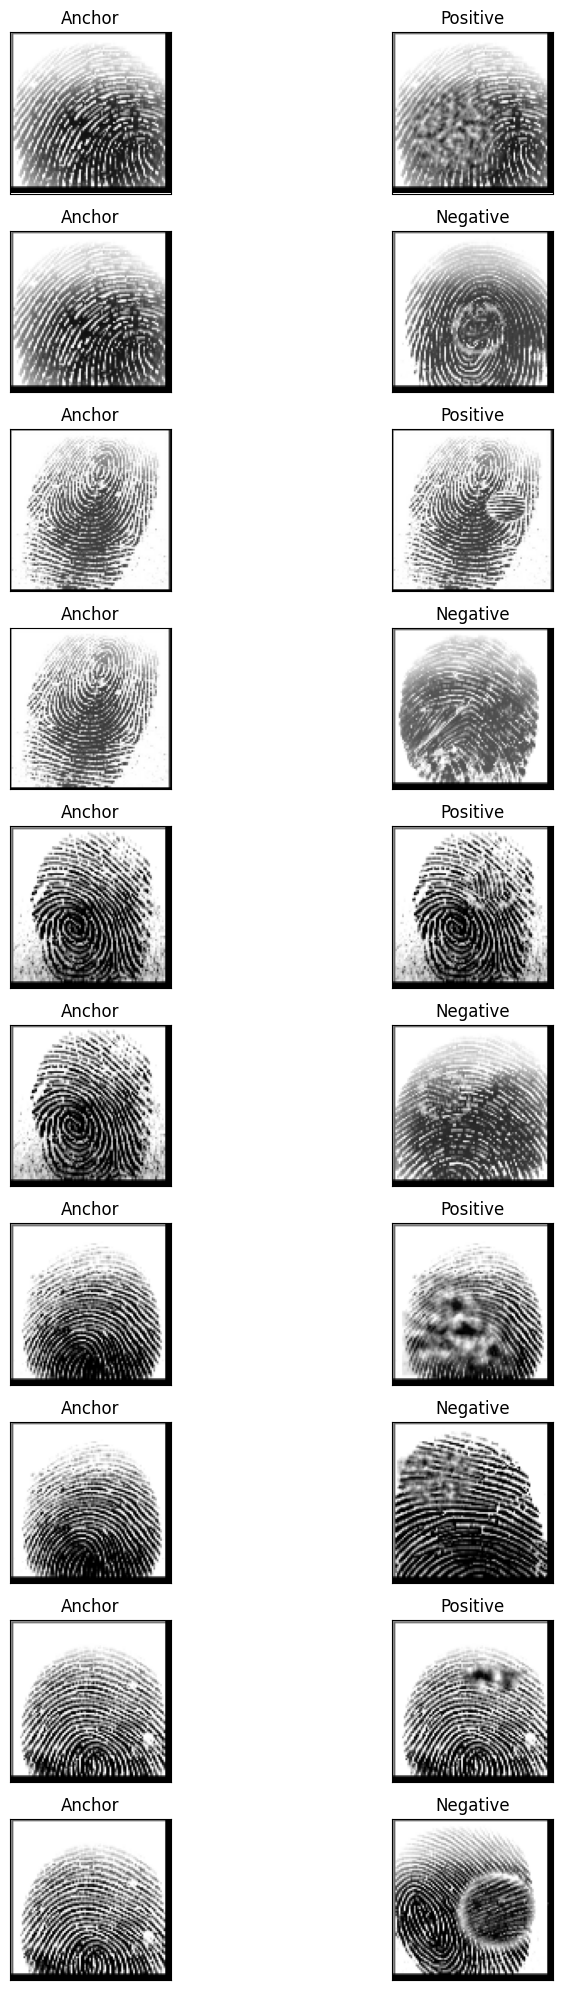

In [ ]:
draw_data(10)

In [ ]:
batch_size = 32
train_gen = get_batch_data(batch_size, ids, dic_data, dic_real)

In [ ]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
  return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [ ]:
input_shape = (96, 96, 1)
network = imgRecoModel(input_shape)
siam_network = build_network(network, input_shape)
siam_network.summary()

(None, 12, 12, 128)
(None, 12, 12, 32)
(None, 12, 12, 32)
(None, 12, 12, 64)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ first_input         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_input        │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImgRecoModel        │ (None, 128)       │  3,720,604 │ first_input[0][0… │
│ (Functional)        │                   │            │ second_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ ImgRecoModel[0][… │
│                     │                   │            │ ImgRecoModel[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,720,604 (14.19 MB)

 Trainable params: 3,719,494 (14.19 MB)

 Non-trainable params: 1,110 (4.34 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=8,
    restore_best_weights=True
)

In [ ]:
rms = RMSprop()
siam_network.compile(loss=contrastive_loss_with_margin(margin=2), optimizer=rms)

In [ ]:
history = siam_network.fit(train_gen, epochs=200, steps_per_epoch=64, callbacks=[early_stop])

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - loss: 0.8893
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.4031
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - loss: 0.3391
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.3394
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.3253
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - loss: 0.3362
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.3263
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - loss: 0.3218
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.2901
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - loss: 0.3025
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.2806
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - loss: 0.2872
Epoch 13/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - loss: 0.2826
Epoch 14/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.2835
Epoch 15/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - lo

In [ ]:
irm = siam_network.get_layer(index=2)
w = irm.get_weights()
p = imgRecoModel(input_shape)
p.set_weights(w)

(None, 12, 12, 128)
(None, 12, 12, 32)
(None, 12, 12, 32)
(None, 12, 12, 64)


In [ ]:
p.save('model_siamese_net1_r.h5')

In [ ]:
id_real = list(dic_real.keys())
len(id_real)

6000

In [ ]:
def compute_distance():
    [anc_pos, neg] = np.random.choice(ids, size=2, replace=False)

    anc_img_path = dic_real[anc_pos][0]
    pos_img_path = np.random.choice(dic_data[anc_pos])
    neg_img_path = np.random.choice(dic_data[neg])

    def preprocess(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)           # Read as grayscale
        img = cv2.resize(img, (96, 96))                        # Resize
        img = img.astype("float32") / 255.0                    # Normalize
        img = np.expand_dims(img, axis=-1)                     # Shape: (96, 96, 1)
        img = np.expand_dims(img, axis=0)                      # Shape: (1, 96, 96, 1)
        return img

    anc_img = preprocess(anc_img_path)
    pos_img = preprocess(pos_img_path)
    neg_img = preprocess(neg_img_path)

    anc_enc = p.predict_on_batch(anc_img)
    pos_enc = p.predict_on_batch(pos_img)
    neg_enc = p.predict_on_batch(neg_img)

    print('Distance between anchor - positive: ', np.linalg.norm(anc_enc - pos_enc))
    print('Distance between anchor - negative: ', np.linalg.norm(anc_enc - neg_enc))

    # For visualization (squeeze and show grayscale)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(anc_img[0, :, :, 0], cmap='gray')
    ax[0].title.set_text('Anchor Image')
    ax[1].imshow(pos_img[0, :, :, 0], cmap='gray')
    ax[1].title.set_text('Positive Image')
    ax[2].imshow(neg_img[0, :, :, 0], cmap='gray')
    ax[2].title.set_text('Negative Image')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()


Distance between anchor - positive:  0.16670379
Distance between anchor - negative:  1.2918264


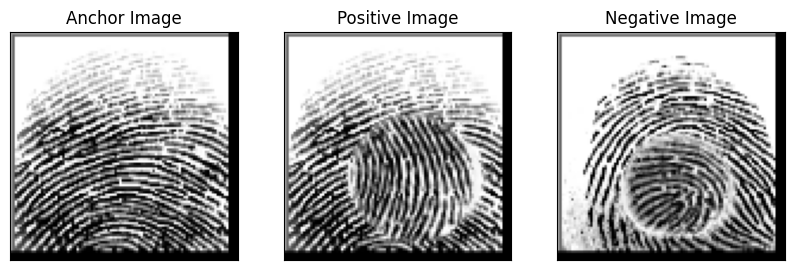

In [ ]:
compute_distance()